In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import os
import subprocess
import gc
import pandas as pd
from scipy.optimize import curve_fit
print("uproot version", uproot.__version__)
print("awkward version", ak.__version__)
print("numpy version", np.__version__)
print("matplotlib version", matplotlib.__version__)
print("hist version", hist.__version__)
print("vector version", vector.__version__)
#print("os version", os.__version__)
#print("subprocess version", subprocess.__version__)
#print("gc version", gc.__version__)
print("pandas version", pd.__version__)
#print("scipy.optimize version", scipy.optimize.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1
pandas version 1.5.3


In [2]:
vector.register_awkward() 

In [3]:
SAMPLE_RUNS = [290323, 290327, 290848, 291361, 291360, 291362, 290853, 290860, 291373, 290374, 290375, 291399,
               291400, 290894, 290895, 290404, 291943, 291944, 291948, 291953, 290932, 290423, 291447, 290935, 
               290425, 290427, 291451, 291453, 291976, 291982, 290456, 290458, 290459, 291482, 291485, 290975, 
               290980, 290469, 292012, 291002, 291003, 291004, 291005, 290501, 292040, 292060, 292061, 292062, 
               291041, 290539, 290540, 292075, 292077, 292080, 290549, 290553, 291590, 292106, 292108, 292109, 
               292115, 290590, 291618, 291622, 291624, 292140, 290612, 292160, 292162, 292163, 292164, 292166, 
               290632, 291657, 292168, 292192, 290658, 290660, 291690, 291692, 291694, 291698, 291706, 290687, 
               290692, 290696, 290699, 292242, 292265, 291755, 292269, 292270, 291760, 292273, 292274, 290742, 
               291769, 291263, 290764, 290766, 291283, 291284, 291285, 291795, 291796, 290776, 291803, 290787]
print(len(SAMPLE_RUNS))

108


In [4]:
def integral(histo: hist.Hist, start: float, stop: float):
    start_bin = histo.axes[0].index(start)  
    stop_bin = histo.axes[0].index(stop)
    return histo[start_bin:stop_bin].sum()

def getTracksData(events):
    return ak.zip({
        "px": events["Muon_Px"],
        "py": events["Muon_Py"],
        "pz": events["Muon_Pz"],
        "E": events["Muon_E"],
        "charge": events["Muon_Charge"],
        "thetaAbs": events["Muon_thetaAbs"],
        "matched": events["Muon_matchedTrgThreshold"]
    }, with_name='Momentum4D')

def scan(dataDescription, 
         hMagData:hist.Hist, hPhiData:hist.Hist, hEtaData:hist.Hist, hYData:hist.Hist, hPtData:hist.Hist, hMassData:hist.Hist, hMass_OSData:hist.Hist, hMass_LSData:hist.Hist,
         eventSelectorData = lambda x:[True]*len(x),
         trackSelectorData = lambda x:[True]*len(x), 
         verbose:bool = False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
        print(dir(vector.backends.awkward.MomentumArray4D))
    """
    Entries = 0
    goodEntries = 0
    Pairs = 0
    goodPairs = 0
            
    for batch in uproot.iterate(dataDescription,
                                ["isCINT", "isCMUL", "isCMSL", "Muon_Px", "Muon_Py", "Muon_Pz", "Muon_E", "Muon_Charge", 
                                 "Muon_thetaAbs", "Muon_matchedTrgThreshold"],                                
                                report = True):

        events = batch[0] # batch[1] is the report info
        
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
        
        goodEvents = events[eventSelectorData(events)] 
        tracks = getTracksData(goodEvents)
        goodTracks = tracks[trackSelectorData(tracks)]

        hMagData.fill(ak.flatten(goodTracks.p))
        hPhiData.fill(ak.flatten(goodTracks.phi))
        hPtData.fill(ak.flatten(goodTracks.pt))
        hYData.fill(ak.flatten(goodTracks.rapidity))
        hEtaData.fill(ak.flatten(goodTracks.eta))
        hMassData.fill(ak.flatten(goodTracks.mass))


        pairs = ak.combinations(goodTracks, 2)

        Px = pairs["0"].px + pairs["1"].px
        Py = pairs["0"].py + pairs["1"].py
        Pz = pairs["0"].pz + pairs["1"].pz
        E = pairs["0"].E + pairs["1"].E
        charge = pairs["0"].charge + pairs["1"].charge

        pairs2 = ak.zip({"px":Px, "py":Py, "pz":Pz, "E":E, "charge":charge}, with_name = 'Momentum4D')

        hMass_OSData.fill(ak.flatten(pairs2[charge == 0].mass))
        hMass_LSData.fill(ak.flatten(pairs2[charge != 0].mass))
        
        Entries += len(events)
        goodEntries += len(ak.flatten(goodTracks))
        Pairs += len(ak.flatten(pairs))
        goodPairs += len(ak.flatten(pairs2[charge == 0]))

        if verbose:
            print("-----------------------------------------------------------")
            print(batch[1], "\nEntries: ", Entries, "\nGood entries: ", goodEntries, "\nPairs: ", Pairs, "\nGood Pairs: ", goodPairs)
        gc.collect()
        
    return Entries, goodEntries, Pairs, goodPairs

In [5]:
%%time

hMag= hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhi = hist.Hist(hist.axis.Regular(bins = 200, start = -22/7, stop = 22/7, name = '$\phi$'))
hEta = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hY = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$y$'))
hPt = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$p_T$'))
hMass = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))

hMass_OS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))
hMass_LS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

Entries = goodEntries = Pairs = goodPairs = 0

for run in SAMPLE_RUNS:
    a, b, c, d = scan(dataDescription = f"/pbs/throng/training/nantes-m2-rps-exp/data/run{run}.data.root:eventsTree",
                      hMagData = hMag, hPhiData = hPhi, hEtaData = hEta, hYData = hY, hPtData = hPt, hMassData = hMass, hMass_OSData = hMass_OS, hMass_LSData = hMass_LS,
                      eventSelectorData = lambda x: x["isCMUL"] == True, 
                      trackSelectorData = lambda x: (x["thetaAbs"] < 10) & (x["thetaAbs"] > 2),# & (x.pt > 0.5) & (x.rapidity < -2.5) & (x.rapidity > -4),
                      verbose = True)
    Entries += a
    goodEntries += b
    Pairs += c
    goodPairs += d

print("-----------------------------------------------------------")
print("Entries: ", Entries, "\nGood entries: ", goodEntries, "\nPairs: ", Pairs, "\nGood Pairs: ", goodPairs)

-----------------------------------------------------------
<Report start=0 stop=2139140 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290323.data.root:/eventsTree;1'> 
Entries:  2139140 
Good entries:  415409 
Pairs:  132477 
Good Pairs:  107291
-----------------------------------------------------------
<Report start=0 stop=190395 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290327.data.root:/eventsTree;1'> 
Entries:  190395 
Good entries:  37031 
Pairs:  11674 
Good Pairs:  9454
-----------------------------------------------------------
<Report start=0 stop=2609146 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290848.data.root:/eventsTree;1'> 
Entries:  2609146 
Good entries:  499188 
Pairs:  154642 
Good Pairs:  124628
-----------------------------------------------------------
<Report start=2609146 stop=2795713 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290848.data.root:/eventsTree;1'> 
Entries:  2795713 
Good entries:  534996 
Pairs:  1657

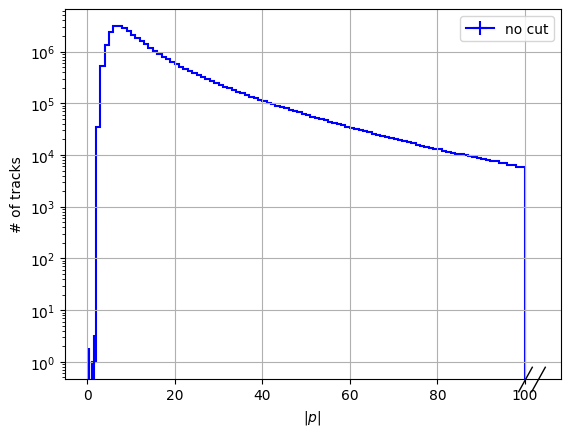

In [6]:
hMag.plot(color = "blue", label = "no cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

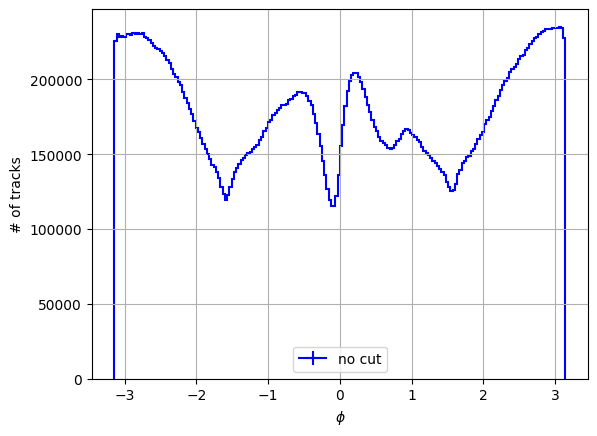

In [7]:
hPhi.plot(color = "blue", label = "no cut")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

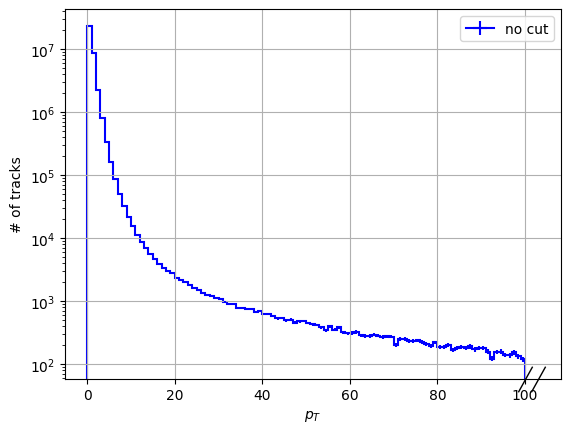

In [8]:
hPt.plot(color = "blue", label = "no cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

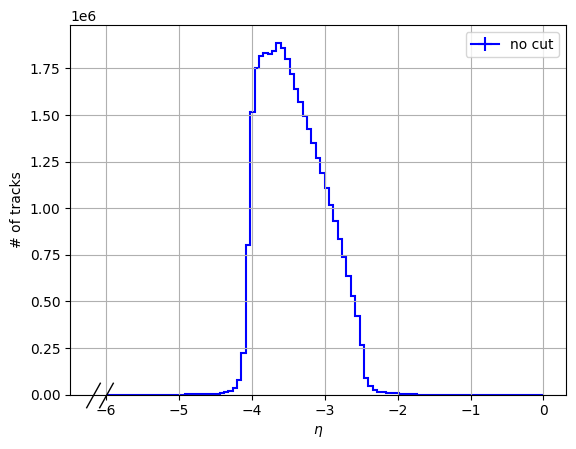

In [9]:
hEta.plot(color = "blue", label = "no cut")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

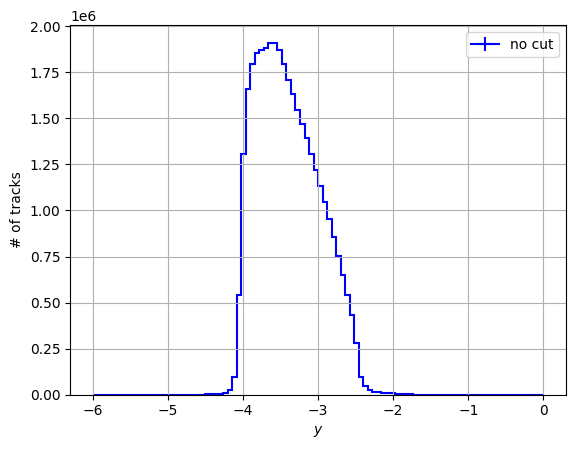

In [10]:
hY.plot(color = "blue", label = "no cut")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

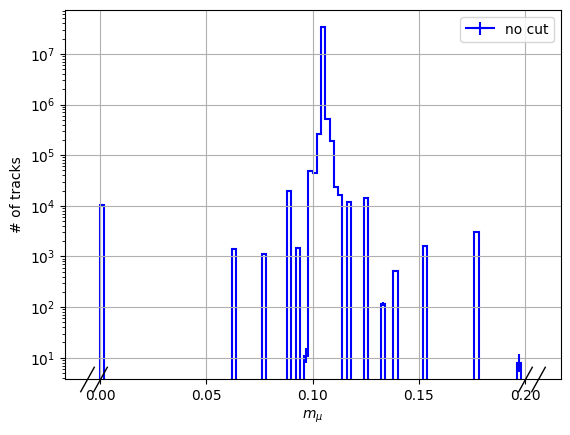

In [11]:
hMass.plot(color = "blue", label = "no cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

610094.0


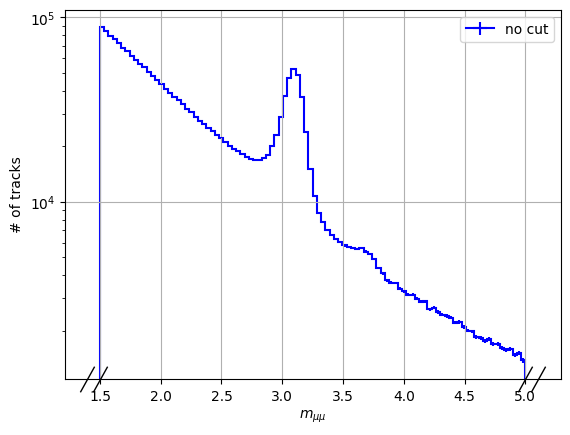

In [12]:
hMass_OS.plot(color = "blue", label = "no cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

print(integral(hMass_OS, 2.5, 3.5))

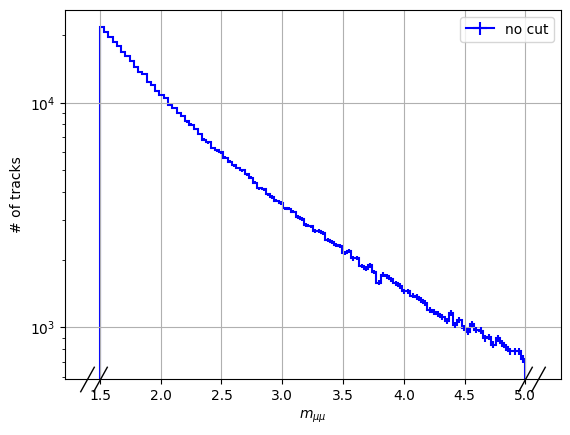

In [13]:
hMass_LS.plot(color = "blue", label = "no cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

In [14]:
print(hMass_OS.axes[0].centers.tolist())
print(hMass_OS.view().tolist())
print(hMass_LS.view().tolist())

[1.5174999999999998, 1.5525, 1.5875, 1.6225, 1.6574999999999998, 1.6925, 1.7275, 1.7625000000000002, 1.7975, 1.8325, 1.8675000000000002, 1.9025000000000003, 1.9375, 1.9725, 2.0075, 2.0425, 2.0775, 2.1125, 2.1475, 2.1825, 2.2175000000000002, 2.2525, 2.2875, 2.3225, 2.3575, 2.3925, 2.4275, 2.4625, 2.4975, 2.5324999999999998, 2.5675, 2.6025, 2.6375, 2.6725000000000003, 2.7075, 2.7424999999999997, 2.7775, 2.8125, 2.8475, 2.8825000000000003, 2.9175000000000004, 2.9524999999999997, 2.9875, 3.0225, 3.0575, 3.0925, 3.1275, 3.1625, 3.1975, 3.2325, 3.2675, 3.3025, 3.3375, 3.3725000000000005, 3.4074999999999998, 3.4425000000000003, 3.4775, 3.5125, 3.5475, 3.5824999999999996, 3.6174999999999997, 3.6525000000000003, 3.6875, 3.7224999999999997, 3.7575000000000003, 3.7925000000000004, 3.8275, 3.8625, 3.8975, 3.9324999999999997, 3.9675, 4.0024999999999995, 4.0375, 4.0725, 4.1075, 4.1425, 4.1775, 4.2125, 4.2475000000000005, 4.2825, 4.3175, 4.352499999999999, 4.3875, 4.422499999999999, 4.4575, 4.4925000

In [15]:
print(dir(vector.backends.awkward.MomentumArray4D))

['E', 'E2', 'Et', 'Et2', 'GenericClass', 'M', 'M2', 'Mask', 'Mt', 'Mt2', 'ProjectionClass2D', 'ProjectionClass3D', 'ProjectionClass4D', '__abs__', '__abstractmethods__', '__add__', '__and__', '__annotations__', '__array__', '__array_function__', '__array_ufunc__', '__arrow_array__', '__bool__', '__bytes__', '__cast_cpp__', '__class__', '__class_getitem__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__divmod__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__'